# Import Brain Inverders Library

In [21]:
from braininvaders2015a.dataset import BrainInvaders2015a

import pandas as pd
import numpy as np

# Import Data

In [12]:
dataset = BrainInvaders2015a()

data_subjects = []
train_subject = 3
session = 'session_1'
run = 'run_1'

In [13]:
train_data = dataset._get_single_subject_data(train_subject)
train_data = train_data[session][run]
print(train_data)

# Preprocessing

## Import Library

In [16]:
import mne
from mne import create_info
from mne.io import RawArray

## Raw data plot

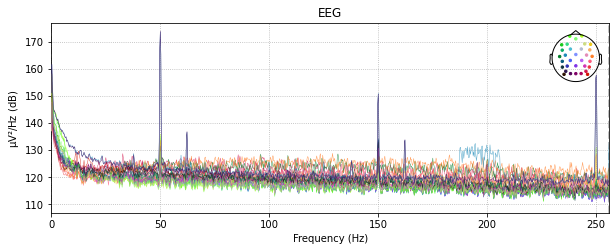

In [18]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
train_data.set_montage(ten_twenty_montage)
train_data.plot_psd();

In [23]:
def df_to_raw(df):
    sfreq = 512
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T
      #mne looks at the tranpose() format
    df[:-1] *= 1e-6
      #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)
    return raw

In [30]:
data_ses1_run1_pd = train_data.to_data_frame()
data_ses1_run1_pd = data_ses1_run1_pd.drop(['time'],axis = 1)
raw = df_to_raw(data_ses1_run1_pd)
raw.notch_filter(np.arange(50, 251, 50))

eeg_channels = mne.pick_types(raw.info, eeg=True)
for cutoff in (0.1, 0.2, 1):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
raw.filter(1,24,method = 'iir')

raw1 = raw.to_data_frame()
X1 = raw1.drop(['time'],axis = 1)
X = X1.drop(['STI 014'],axis = 1)
y = raw1['STI 014']



Creating RawArray with float64 data, n_channels=33, n_times=132160
    Range : 0 ... 132159 =      0.000 ...   258.123 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16897 samples (33.002 sec)

Filtering raw data in 1 contiguous seg

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=32)
X_r = pca.fit(X.values).transform(X.values)
print(X_r)
y1 = y.values.reshape(-1,1)
print(y1.shape)
data = np.hstack((X_r,y1))
print(data)
df = pd.DataFrame(data, columns = list(X1.columns))

[[ 2.86028273e+04 -1.59569547e+05 -2.03616807e+04 ... -4.20226113e+03
   2.86846036e+03 -1.06508634e+04]
 [ 2.55508815e+07  2.26549318e+07 -2.30370897e+06 ... -3.58789229e+05
   8.73605114e+04  4.11206456e+05]
 [ 5.02107287e+07  4.44141417e+07 -4.40673067e+06 ... -6.94309669e+05
   1.68323673e+05  8.20916665e+05]
 ...
 [ 1.06686425e+08  2.02674641e+08  1.85212233e+07 ... -7.04890756e+05
  -1.94075642e+06  2.57154577e+05]
 [ 5.42990189e+07  1.03224035e+08  9.34790199e+06 ... -3.40525234e+05
  -9.91882977e+05  1.40247705e+05]
 [-3.66360525e+05 -4.22286436e+05 -2.19116902e+05 ...  3.25162600e+04
  -7.52226727e+03  1.38099652e+04]]
(132160, 1)
[[ 2.86028273e+04 -1.59569547e+05 -2.03616807e+04 ...  2.86846036e+03
  -1.06508634e+04  0.00000000e+00]
 [ 2.55508815e+07  2.26549318e+07 -2.30370897e+06 ...  8.73605114e+04
   4.11206456e+05  0.00000000e+00]
 [ 5.02107287e+07  4.44141417e+07 -4.40673067e+06 ...  1.68323673e+05
   8.20916665e+05  0.00000000e+00]
 ...
 [ 1.06686425e+08  2.02674641e+0

In [32]:
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=33, n_times=132160
    Range : 0 ... 132159 =      0.000 ...   258.123 secs
Ready.


In [33]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [34]:
event_id = {'NonTarget': 1, 'Target': 2}
tmin = 0.0 #0
tmax = 1.0 #0.5 seconds
picks= eeg_channels
epochs = getEpochs(raw,event_id, tmin, tmax, picks)

360 events found
Event IDs: [1 2]
sample drop %:  0.0


In [35]:
X = epochs.get_data()
y = epochs.events[:, -1]

In [36]:
print(X.shape)
print(y.shape)

(360, 32, 513)
(360,)


# Model

## Import torch

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## CM-CW-CNN Model

In [38]:
class CM_CW_CNN(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self):
        super(CM_CW_CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,kernel_size=(32,1),stride=(1,1)))
        self.conv2 = nn.Sequential(nn.Conv2d(16,16,kernel_size=(1,57),stride=(1,57)))
        self.fc = nn.Sequential(nn.Linear(144,144),nn.ReLU(),nn.Dropout(0.5),
                               nn.Linear(144,48),nn.Dropout(0.5),
                               nn.Linear(48,12),
                               nn.Linear(12,3))
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        #print("X",x.shape)
        x = x.flatten(start_dim = 1)
        #print("X flatten",x.shape)
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [39]:
model = CM_CW_CNN()
model = model.float()

In [40]:
import torch.optim as optim

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## Data reshape

In [43]:
X_newaxis = X[:, np.newaxis, :, :]
torch_X = torch.from_numpy(X_newaxis)
torch_y = torch.from_numpy(y)
print("Original X: ", torch_X.size())
torch_X_reshaped = torch_X
print("Reshaped X: ", torch_X.size())

Original X:  torch.Size([360, 1, 32, 513])
Reshaped X:  torch.Size([360, 1, 32, 513])


## Data Loader, Test/Train Split

In [44]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(round(torch_X_reshaped.size()[0] * 0.7))
valid_size = int(round(torch_X_reshaped.size()[0] * 0.1))
test_size = int(round(torch_X_reshaped.size()[0] * 0.2))


train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [ ]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []

    trues = []
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        print('================== Predicted y ====================')
        print(predicted)
        predicteds.append(predicted)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        print('==================    True y   ====================')
        print(labels)
        trues.append(labels)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicteds, trues